# HNA Demo Notebook

This notebook gives a demo of the hybrid neural autoencoders for visual prostheses used in the paper. The accompanying assets folder must be present. We recommend using google colab to simplify setup. If using colab, the whole containing folder should be uploaded to colab

### Installation

Notebook requirements: 
- numpy
- matplotlib
- tensorflow
- scikit-learn
- pulse2percept (Beyeler 2019)

pulse2percept also requires cython to be installed. 

If you are running in colab, all of the requirements except pulse2percept will already be installed

In [ ]:
""" Common dependencies (preinstalled on colab) """
#!pip install numpy matplotlib tensorflow scikit-learn cython

In [ ]:
""" pulse2percept """
!pip install git+https://github.com/pulse2percept/pulse2percept

## Demo

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from pulse2percept.models import BiphasicAxonMapModel

from assets.HNA import UniversalBiphasicAxonMapLayer, NaiveEncoding, RectangleImplant, load_mnist, get_vgg_loss, get_patient_params, load_model

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

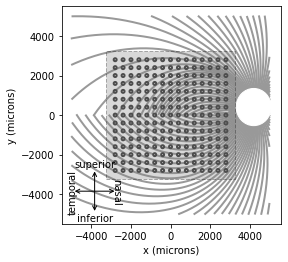

In [13]:
# Make a p2p BiphasicAxonMapModel. This is mostly a placeholder that the tensorflow model gets parameter values from (e.g. image size, axon structure)
p2pmodel = BiphasicAxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.5, a0=0, a1=1, engine='jax', min_ax_sensitivity=0.25, n_ax_segments=300)
p2pmodel.build()
implant = RectangleImplant()

p2pmodel.plot()
implant.plot()

Load the mnist HNA model, and define the joint loss

In [18]:
hna = load_model("assets/HNA_mnist.tf/", p2pmodel, implant)
# Use the joint perceptual loss (final version, alpha=0)
loss = get_vgg_loss(beta=0.00008)
hna.compile(loss=loss, metrics=['mae'])
hna.summary()

This is the HNA trained across all patient parameters (phi). Note that if you want even better results for a specific patient, its better to train a model separately for that. 

Lets also load a naive encoder

In [38]:
inputs = layers.Input(shape=targets[0].shape)
phi = layers.Input(shape=(12), dtype='float32', name='modelparams_input')
stims = NaiveEncoding(implant, stimrange=(0, 2))(inputs)
outputs = UniversalBiphasicAxonMapLayer(p2pmodel, implant, amp_cutoff=True)([stims, phi])
naive = tf.keras.Model([inputs, phi], outputs)
naive.compile(loss=loss, metrics=['mae'])
naive.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 49, 49, 1)]  0                                            
__________________________________________________________________________________________________
Naive (NaiveEncoding)           (None, None, 3)      0           input_4[0][0]                    
__________________________________________________________________________________________________
modelparams_input (InputLayer)  [(None, 12)]         0                                            
__________________________________________________________________________________________________
UniversalBiphasicAxonMap (Unive (None, 49, 49)       0           Naive[0][0]                      
                                                                 modelparams_input[0][0]    

Load the target MNIST images

In [20]:
(targets, labels), (targets_test, labels_test) = load_mnist(p2pmodel, scale=2.0, pad=1)

Get patient-specific parameters phi. Lets vary rho and lambda for the first patients in the test set

In [45]:
phis, phis_test = get_patient_params(p2pmodel, targets, targets_test)
phis_test[:15, 0] = np.linspace(100, 800, 15)
phis_test[:15, 1] = np.linspace(100, 2000, 15)

Get predictions for the first 15 images

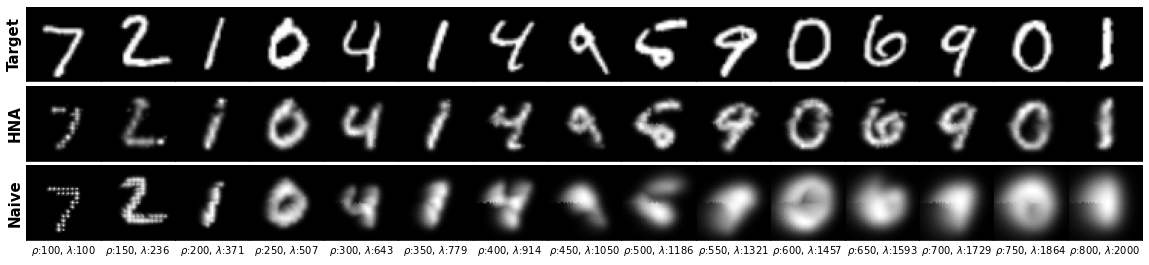

In [46]:
preds = hna.predict([targets_test[:15], phis_test[:15]])
preds_naive = naive.predict([targets_test[:15], phis_test[:15]])

# plot
fig, axes = plt.subplots(3, 15, figsize=(20, 5))
plt.subplots_adjust(wspace=0, hspace=-0.3)
for ax, target in zip(axes[0], targets_test[:15]):
    ax.imshow(target, cmap='gray')
for ax, pred in zip(axes[1], preds):
    ax.imshow(pred, cmap='gray')
for ax, pred_naive, r, l in zip(axes[2], preds_naive, phis_test[:15, 0], phis_test[:15, 1]):
    ax.imshow(pred_naive, cmap='gray')
    ax.set_xlabel(fr"$\rho$:{r:.0f}, $\lambda$:{l:.0f}")
    
# make it look nice
for ax in axes.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
axes[0][0].set_ylabel("Target", fontweight='bold', fontsize=15)
axes[1][0].set_ylabel("HNA", fontweight='bold', fontsize=15)
axes[2][0].set_ylabel("Naive", fontweight='bold', fontsize=15)
plt.show()

We can also evaluate the loss across the entire test set for random patients. Note that for this model we can only vary rho and lambda

In [48]:
phis, phis_test = get_patient_params(p2pmodel, targets, targets_test)
phis_test[:, 0] = np.random.randint(75, 800, size=len(phis_test))
phis_test[:, 1] = np.random.randint(50, 2000, size=len(phis_test))

hna.evaluate([targets_test, phis_test], targets_test, batch_size=8)
naive.evaluate([targets_test, phis_test], targets_test, batch_size=8)

1250/1250 [==============================] - 59s 47ms/step - loss: 3.1635 - mae: 0.5970


[3.1635446548461914, 0.5969599485397339]

Note that since we are using a new set of random patients, the loss is very slightly different than the values reported in the paper